## Section 1: Project Setup and Data Ingestion
Our first step is to set up the environment by importing the necessary Python libraries. We'll use `pandas` and `numpy` for data manipulation, `matplotlib` and `seaborn` for static visualizations, and `plotly` for interactive plots. We also set some default styles for our plots to ensure they are clear and aesthetically pleasing.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

sns.set_style('whitegrid')
plt.style.use('seaborn-v0_8-talk')

print("Libraries imported successfully.")

Libraries imported successfully.


With the libraries loaded, we can now ingest our dataset. For this project, we are using a publicly available, anonymized insurance dataset hosted on a public URL. We'll load this directly into a pandas DataFrame, which is the primary data structure we'll use for our analysis.

In [18]:
try:
    url = 'https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv'
    df = pd.read_csv(url)
    print("Dataset loaded successfully.")
    print(f"Dataset shape: {df.shape}")
except Exception as e:
    print(f"Error loading dataset: {e}")

Dataset loaded successfully.
Dataset shape: (1338, 7)


## Section 2: Data Cleaning and Initial Inspection
Before diving into analysis, it's crucial to get a high-level overview of the data. We'll use `.head()` to see the first few rows, `.info()` to understand the data types and non-null counts, and `.describe()` to get a statistical summary of the numerical columns. This helps us quickly identify the structure and scale of our data.

In [19]:
print("\n--- First 5 Rows of the Dataset ---")
print(df.head())

print("\n--- Dataset Information ---")
df.info()

print("\n--- Statistical Summary ---")
print(df.describe())


--- First 5 Rows of the Dataset ---
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

--- Dataset Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB

--- Statistical Summary ---
 

Data quality is paramount for any reliable analysis. A key step in data cleaning is checking for missing values. We'll use `.isnull().sum()` to count the number of nulls in each column. Fortunately, this dataset is clean, but in a real-world scenario, we would need to decide on a strategy (e.g., imputation or removal) to handle any missing data found here.

In [20]:
print("\n--- Missing Values per Column ---")
print(df.isnull().sum())


--- Missing Values per Column ---
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


## Section 3: Exploratory Data Analysis (EDA)
Now we move to Exploratory Data Analysis (EDA). The first step is to understand the distribution of our key numerical features. By plotting histograms for attributes like Age, Annual Premium, and Policy Tenure, we can visualize their shape, central tendency, and spread, which provides initial insights into our customer base.


--- Starting Exploratory Data Analysis ---


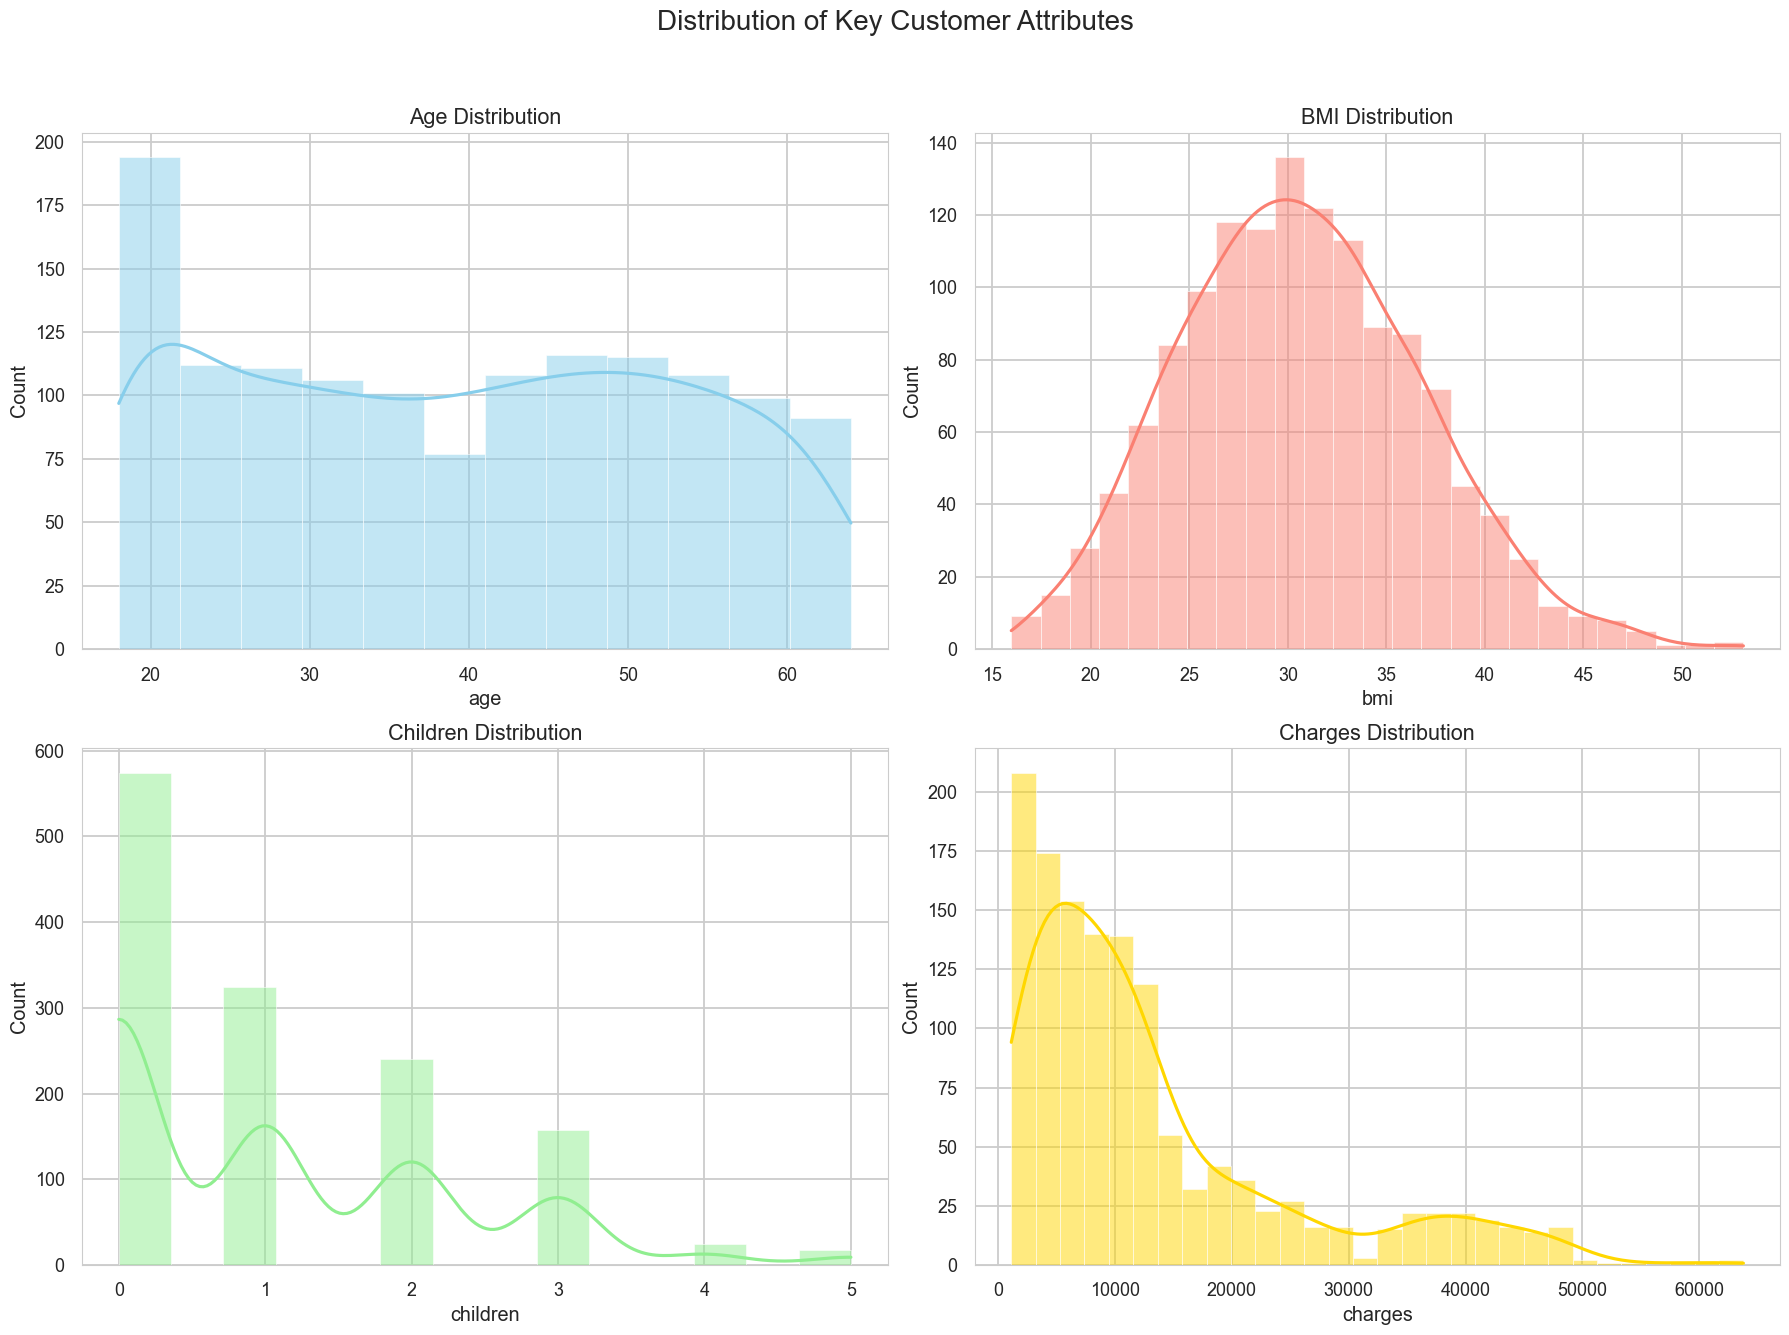

In [21]:
print("\n--- Starting Exploratory Data Analysis ---")

fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Distribution of Key Customer Attributes', fontsize=20)

sns.histplot(df['age'], kde=True, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Age Distribution')

sns.histplot(df['bmi'], kde=True, ax=axes[0, 1], color='salmon')
axes[0, 1].set_title('BMI Distribution')

sns.histplot(df['children'], kde=True, ax=axes[1, 0], color='lightgreen')
axes[1, 0].set_title('Children Distribution')

sns.histplot(df['charges'], kde=True, ax=axes[1, 1], color='gold')
axes[1, 1].set_title('Charges Distribution')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

To understand how our numerical variables relate to one another, we'll create a correlation heatmap. This visualization shows the correlation coefficient between each pair of features, ranging from -1 (perfect negative correlation) to +1 (perfect positive correlation). It's a powerful tool for identifying potential multicollinearity and discovering interesting relationships in the data.

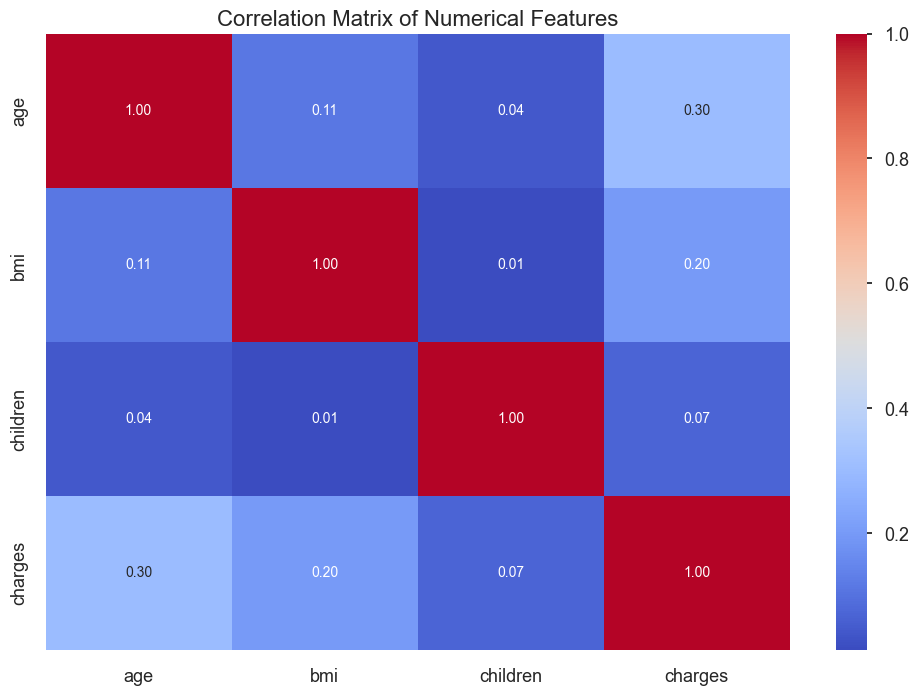

In [22]:
plt.figure(figsize=(12, 8))
numeric_df = df.select_dtypes(include=np.number)
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.show()